In [ ]:
# Import stuff here
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import time
import os
import logging
import re

# import keras
# import eli5
# import tensorflow

# Steps: 

## Pick CPU or GPU and define helper functions for that
## Load and Transform Dataset
## Define Important Functions
## Build the Model Class
## Train&Test the 5 Models

------------------------------------------------------------

## CPU GPU Stuff

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
print(device)
print(type(device))

cuda
<class 'torch.device'>


In [ ]:
# Important helper function that moves tensors and models to any Device
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
# This is a DataLoader wrapper which wraps normal DataLoaders and make them work with GPU
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

## Load Dataset

In [ ]:
# Important Constants here

NUM_CLASSES = 198
IMG_SIZE = 224

# DATASET_DIR = 'dataset'
DATASET_DIR = '/home/jovyan/data/dataset'

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [ ]:
class MyLazyDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        
        # y = [0] * NUM_CLASSES
        # y[dataset[index][1]] = 1
        # y = torch.LongTensor(y)

        y = dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(dataset)

# Training transform includes random rotation and flip to build a more robust model
train_transforms = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

# Test tranform is just the normal stuff
test_transforms = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                      transforms.CenterCrop(IMG_SIZE),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

# Load the training set
training_set = datasets.ImageFolder(os.path.join(DATASET_DIR, 'train'), train_transforms)

# Load the testing set
testing_set = datasets.ImageFolder(os.path.join(DATASET_DIR, 'test'), test_transforms)

In [ ]:
print(len(training_set), len(testing_set))

37245 9316


In [ ]:
# Make DataLoaders
training_loader = DataLoader(
    training_set, 
    batch_size=32,
    shuffle=True,
    num_workers=0
)

testing_loader = DataLoader(
    testing_set, 
    batch_size=64,
    shuffle=True,
    num_workers=0
)

# del training_set, testing_set

In [ ]:
# Transfer DataLoaders to GPU if possible
training_loader = DeviceDataLoader(training_loader, device)
testing_loader = DeviceDataLoader(testing_loader, device)

In [ ]:
hierarchy_dict = {"Acura":["Acura TL Type-S 2008","Acura TSX Sedan 2012","Acura ZDX Hatchback 2012"],
                  "AM General":["AM General Hummer SUV 2000"],
                 "Aston Martin":["Aston Martin V8 Vantage Convertible 2012","Aston Martin V8 Vantage Coupe 2012","Aston Martin Virage Convertible 2012","Aston Martin Virage Coupe 2012"],
                 "Audi":["Audi 100 Sedan 1994","Audi 100 Wagon 1994","Audi A5 Coupe 2012","Audi R8 Coupe 2012","Audi RS 4 Convertible 2008","Audi S4 Sedan 2007","Audi S4 Sedan 2012","Audi S5 Convertible 2012","Audi S5 Coupe 2012","Audi S6 Sedan 2011","Audi TT Hatchback 2011","Audi TT RS Coupe 2012","Audi TTS Coupe 2012","Audi V8 Sedan 1994"],
                 "Bentley":["Bentley Arnage Sedan 2009","Bentley Continental Flying Spur Sedan 2007","Bentley Continental GT Coupe 2007","Bentley Continental GT Coupe 2012","Bentley Mulsanne Sedan 2011"],
                 "BMW":["BMW 1 Series Convertible 2012","BMW 1 Series Coupe 2012","BMW 3 Series Sedan 2012","BMW 3 Series Wagon 2012","BMW 6 Series Convertible 2007","BMW ActiveHybrid 5 Sedan 2012","BMW M3 Coupe 2012","BMW M5 Sedan 2010","BMW M6 Convertible 2010","BMW X3 SUV 2012","BMW X5 SUV 2007","BMW X6 SUV 2012","BMW Z4 Convertible 2012"],
                 "Bugatti":["Bugatti Veyron 16.4 Convertible 2009","Bugatti Veyron 16.4 Coupe 2009"],
                 "Buick":["Buick Enclave SUV 2012","Buick Rainier SUV 2007","Buick Regal GS 2012","Buick Verano Sedan 2012"],
                 "Cadillac":["Cadillac CTS-V Sedan 2012","Cadillac Escalade EXT Crew Cab 2007","Cadillac SRX SUV 2012"],
                 "Chevrolet":["Chevrolet Avalanche Crew Cab 2012","Chevrolet Camaro Convertible 2012","Chevrolet Cobalt SS 2010","Chevrolet Corvette Convertible 2012","Chevrolet Corvette Ron Fellows Edition Z06 2007","Chevrolet Corvette ZR1 2012","Chevrolet Express Cargo Van 2007","Chevrolet Express Van 2007","Chevrolet HHR SS 2010","Chevrolet Impala Sedan 2007","Chevrolet Malibu Hybrid Sedan 2010","Chevrolet Malibu Sedan 2007","Chevrolet Monte Carlo Coupe 2007","Chevrolet Silverado 1500 Classic Extended Cab 2007","Chevrolet Silverado 1500 Extended Cab 2012","Chevrolet Silverado 1500 Hybrid Crew Cab 2012","Chevrolet Silverado 1500 Regular Cab 2012","Chevrolet Silverado 2500HD Regular Cab 2012","Chevrolet Sonic Sedan 2012","Chevrolet Tahoe Hybrid SUV 2012","Chevrolet TrailBlazer SS 2009","Chevrolet Traverse SUV 2012"],
                 "Chrysler":["Chrysler 300 SRT-8 2010","Chrysler Aspen SUV 2009","Chrysler Crossfire Convertible 2008","Chrysler PT Cruiser Convertible 2008","Chrysler Sebring Convertible 2010","Chrysler Town and Country Minivan 2012"],
                 "Daewoo":["Daewoo Nubira Wagon 2002"],
                 "Dodge":["Dodge Caliber Wagon 2007","Dodge Caliber Wagon 2012","Dodge Caravan Minivan 1997","Dodge Challenger SRT8 2011","Dodge Charger Sedan 2012","Dodge Charger SRT-8 2009","Dodge Dakota Club Cab 2007","Dodge Dakota Crew Cab 2010","Dodge Durango SUV 2007","Dodge Durango SUV 2012","Dodge Journey SUV 2012","Dodge Magnum Wagon 2008","Dodge Ram Pickup 3500 Crew Cab 2010","Dodge Ram Pickup 3500 Quad Cab 2009","Dodge Sprinter Cargo Van 2009"],
                 "Eagle":["Eagle Talon Hatchback 1998"],
                 "Ferrari":["Ferrari 458 Italia Convertible 2012","Ferrari 458 Italia Coupe 2012","Ferrari California Convertible 2012","Ferrari FF Coupe 2012"],
                 "FIAT":["FIAT 500 Abarth 2012","FIAT 500 Convertible 2012"],
                 "Fisker":["Fisker Karma Sedan 2012"],
                 "Ford":["Ford Edge SUV 2012","Ford E-Series Wagon Van 2012","Ford Expedition EL SUV 2009","Ford F-150 Regular Cab 2007","Ford F-150 Regular Cab 2012","Ford F-450 Super Duty Crew Cab 2012","Ford Fiesta Sedan 2012","Ford Focus Sedan 2007","Ford Freestar Minivan 2007","Ford GT Coupe 2006","Ford Mustang Convertible 2007","Ford Ranger SuperCab 2011"],
                 "Geo":["Geo Metro Convertible 1993"],
                 "GMC":["GMC Acadia SUV 2012","GMC Canyon Extended Cab 2012","GMC Savana Van 2012","GMC Terrain SUV 2012","GMC Yukon Hybrid SUV 2012"],
                 "Honda":["Honda Accord Coupe 2012","Honda Accord Sedan 2012","Honda Odyssey Minivan 2007","Honda Odyssey Minivan 2012"],
                 "HUMMER":["HUMMER H2 SUT Crew Cab 2009","HUMMER H3T Crew Cab 2010"],
                 "Hyundai":["Hyundai Accent Sedan 2012","Hyundai Azera Sedan 2012","Hyundai Elantra Sedan 2007","Hyundai Elantra Touring Hatchback 2012","Hyundai Genesis Sedan 2012","Hyundai Santa Fe SUV 2012","Hyundai Sonata Hybrid Sedan 2012","Hyundai Sonata Sedan 2012","Hyundai Tucson SUV 2012","Hyundai Veloster Hatchback 2012","Hyundai Veracruz SUV 2012"],
                 "Infiniti":["Infiniti G Coupe IPL 2012","Infiniti QX56 SUV 2011"],
                 "Isuzu":["Isuzu Ascender SUV 2008"],
                 "Jaguar":["Jaguar XK XKR 2012"],
                 "Jeep":["Jeep Compass SUV 2012","Jeep Grand Cherokee SUV 2012","Jeep Liberty SUV 2012","Jeep Patriot SUV 2012","Jeep Wrangler SUV 2012"],
                 "Lamborghini":["Lamborghini Aventador Coupe 2012","Lamborghini Diablo Coupe 2001","Lamborghini Gallardo LP 570-4 Superleggera 2012","Lamborghini Reventon Coupe 2008"],
                 "Land Rover":["Land Rover LR2 SUV 2012","Land Rover Range Rover SUV 2012"],
                 "Lincoln":["Lincoln Town Car Sedan 2011"],
                 "Maybach":["Maybach Landaulet Convertible 2012"],
                 "Mazdz":["Mazda Tribute SUV 2011"],
                 "McLaren":["McLaren MP4-12C Coupe 2012"],
                 "Mercedes-Benz":["Mercedes-Benz 300-Class Convertible 1993","Mercedes-Benz C-Class Sedan 2012","Mercedes-Benz E-Class Sedan 2012","Mercedes-Benz G-Class","Mercedes-Benz S-Class Sedan 2012","Mercedes-Benz SL-Class Coupe 2009","Mercedes-Benz Sprinter Van 2012"],
                 "MINI":["MINI Cooper Roadster Convertible 2012"],
                 "Mitsubishi":["Mitsubishi Lancer Sedan 2012"],
                 "Nissan":["Nissan 240SX Coupe 1998","Nissan Juke Hatchback 2012","Nissan Leaf Hatchback 2012","Nissan NV Passenger Van 2012"],
                 "Plymouth":["Plymouth Neon Coupe 1999"],
                 "Porsche":["Porsche Panamera Sedan 2012"],
                 "Ram":["Ram C-V Cargo Van Minivan 2012"],
                 "Rolls-Royce":["Rolls-Royce Ghost Sedan 2012","Rolls-Royce Phantom Drophead Coupe Convertible 2012","Rolls-Royce Phantom Sedan 2012"],
                 "Scion":["Scion xD Hatchback 2012"],
                 "Smart":["smart fortwo Convertible 2012"],
                 "Spyker":["Spyker C8 Convertible 2009","Spyker C8 Coupe 2009"],
                 "Suzuki":["Suzuki Aerio Sedan 2007","Suzuki Kizashi Sedan 2012","Suzuki SX4 Hatchback 2012","Suzuki SX4 Sedan 2012"],
                 "Tesla":["Tesla Model S Sedan 2012"],
                 "Toyota":["Toyota 4Runner SUV 2012","Toyota Camry Sedan 2012","Toyota Corolla Sedan 2012","Toyota Prado","Toyota Sequoia SUV 2012"],
                 "Volkswagen":["Volkswagen Beetle Hatchback 2012","Volkswagen Golf Hatchback 1991","Volkswagen Golf Hatchback 2012"],
                 "Volvo":["Volvo 240 Sedan 1993","Volvo C30 Hatchback 2012","Volvo XC90 SUV 2007"]}

In [ ]:
for subclass in hierarchy_dict.values():
    for model in subclass:
        if not model in testing_set.classes:
            print(model)

seen = []
for subclass in hierarchy_dict.values():
    for model in subclass:
        if model in seen:
            print(model)
        seen.append(model)

# -----Training-----

## Define Important Functions

In [ ]:
def evaluate(model, val_loader):
    with torch.no_grad():
        model.eval()
        outputs = [model.validation_step(batch) for batch in val_loader]
        # outputs = []
        # for batch in val_loader:
        #     print(69)
        #     outputs.append(model.validation_step(batch))
        return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader, optimizer, scheduler, folder):
    start_time = time.time()
    
    # Loggers
    train_logger = logging.getLogger(f'{model.variant}->train_logger')
    train_logger.setLevel(logging.DEBUG)

    formatter = logging.Formatter('%(asctime)s:%(name)s:%(message)s')

    train_file_handler = logging.FileHandler(os.path.join(folder, 'train_logs.log'))
    train_file_handler.setFormatter(formatter)
    train_logger.addHandler(train_file_handler)

    epoch_logger = logging.getLogger(f'{model.variant}->epoch_end_logger')
    epoch_logger.setLevel(logging.INFO)

    epoch_file_handler = logging.FileHandler(os.path.join(folder, 'epoch_end_logs.log'))
    epoch_file_handler.setFormatter(formatter)
    epoch_logger.addHandler(epoch_file_handler)

    from tqdm.notebook import tqdm

    for epoch in range(epochs):
        # Training Phase 
        print('Epoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)
        model.train()
        epoch_pbar = tqdm(train_loader, total=int(len(train_loader)))

        running_loss = 0.0
        for i, batch in enumerate(epoch_pbar):
            # Training stuff
            optimizer.zero_grad()
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            # scheduler.step()

            running_loss += loss.item() * 32
            epoch_pbar.set_postfix(loss=(running_loss / ((i+1) * 32)), lr=optimizer.param_groups[0]['lr'])
            epoch_pbar.update()

            train_logger.debug(f'Epoch: {epoch+1}, Training_Loss: {running_loss / ((i+1) * 32)}')
            pass

        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        scheduler.step(result['val_acc'])
        epoch_logger.info(f"Epoch: {epoch+1} Validation Loss: {result['val_loss']}, Validation Acc: {result['val_acc']}")

        print(f"Epoch: {epoch+1}, Validation Loss: {result['val_loss']}, Validation Accuracy: {result['val_acc']}")
    
    end_time = time.time()
    time_elapsed = end_time - start_time
    print(f'Finished Training, Time Elapsed: {time_elapsed}s')

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

## Build the ResNet Class

In [ ]:
class MyModel(nn.Module):
    def __init__(self, variant, pretrained):
        super(MyModel, self).__init__()
        
        if variant in ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']:
            if variant is 'resnet18':
                resnet_part = models.resnet18(pretrained=pretrained)
            elif variant is 'resnet34':
                resnet_part = models.resnet34(pretrained=pretrained)
            elif variant is 'resnet50':
                resnet_part = models.resnet50(pretrained=pretrained)
            elif variant is 'resnet101':
                resnet_part = models.resnet101(pretrained=pretrained)
            elif variant is 'resnet152':
                resnet_part = models.resnet152(pretrained=pretrained)

            resnet_part.fc = nn.Linear(resnet_part.fc.in_features, 512)
            self.net = nn.Sequential(
                resnet_part, 
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Linear(512, NUM_CLASSES),
                nn.LogSoftmax(dim=1)
            )
        elif variant is 'mobilenet_v2':
            self.net = models.mobilenet_v2(pretrained=pretrained)
            self.net.classifier = nn.Sequential(
                nn.Dropout(p=0.2, inplace=False),
                nn.Linear(1280, 512),
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Linear(512, NUM_CLASSES),
                nn.LogSoftmax(dim=1)
            )
        elif variant is 'densenet':
            self.net = models.densenet.DenseNet()
            self.net.classifier = nn.Sequential(
                nn.Linear(in_features=1024, out_features=512, bias=True),
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Linear(512, NUM_CLASSES),
                nn.LogSoftmax(dim=1)
            )
        
        self.loss_func = nn.CrossEntropyLoss()
        self.variant = variant
        
        # For testing
        self.confusion_matrix = None
    
    def forward(self, x):
        output = self.net(x)
        return output
    
    def training_step(self, batch):
        images, labels = batch 
        images = to_device(images, device)
        labels = to_device(labels, device)
        out = self(images)
        loss = self.loss_func(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        images = to_device(images, device)
        labels = to_device(labels, device)
        out = self(images)
        loss = self.loss_func(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

    def save_model(self, filename):
        torch.save(self.state_dict(), filename)

    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
      
    def get_num_train_params(self):
        model_parameters = filter(lambda p: p.requires_grad, self.net.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        return params
    
    def get_num_params(self):
        return sum(p.numel() for p in model.parameters())

# Training the Final Models for Comparison

## Get sizes of every model

In [ ]:
variants = ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'mobilenet_v2', 'densenet']

for variant in variants:
    model = MyModel(variant=variant, pretrained=False)
    print(variant, model.get_num_params()/10000000)

resnet18 1.1540742
resnet34 2.1648902
resnet50 2.4658694
resnet101 4.3650822
resnet152 5.929447
mobilenet_v2 0.2981318
densenet 0.758023


## Fit Loop Wrapper

In [ ]:
def ultimate_train(variant, init_lr, epochs, device, folder, filename):
    model = MyModel(variant=variant, pretrained=True)
    model = to_device(model, device)

    # Get stats b4 training
    print('Getting Stats B4 training....')
    result0 = evaluate(model, testing_loader)
    print('Stats b4 training', result0)

    # Legit Training
    optimizer = optim.Adam(model.parameters(), lr=init_lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max',
        patience=3,
        threshold=0.9,
        verbose=False
    )
    
    fit(epochs, model, training_loader, testing_loader, optimizer, scheduler, folder)

    # Save Model
    model.save_model(os.path.join(folder, filename))

## ResNet18

In [ ]:
ultimate_train('resnet18', 0.0001, 30, device,
               '/home/jovyan/work/model_training_featurize/models/ResNet18', 'ResNet18_9_5')

## ResNet34

In [ ]:
ultimate_train('resnet34', 0.0001, 30, device,
               '/home/jovyan/work/model_training_featurize/models/ResNet34', 'ResNet34_9_5')

## ResNet50

In [ ]:
ultimate_train('resnet50', 0.0001, 30, device,
               '/home/jovyan/work/model_training_featurize/models/ResNet50', 'ResNet50_9_5')

## ResNet101

In [ ]:
ultimate_train('resnet101', 0.0001, 30, device,
               '/home/jovyan/work/model_training_featurize/models/ResNet101', 'ResNet101_9_5')

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


## ResNet152

In [ ]:
ultimate_train('resnet152', 0.0001, 30, device,
               '/home/jovyan/work/model_training_featurize/models/ResNet152', 'ResNet152_9_5')

## DenseNet

In [ ]:
ultimate_train('densenet', 0.0001, 30, device,
               '/home/jovyan/work/model_training_featurize/models/DenseNet', 'DenseNet_9_7')

## MobileNet

In [ ]:
ultimate_train('mobilenet_v2', 0.0001, 30, device,
               '/home/jovyan/work/model_training_featurize/models/MobileNet_V2', 'MobileNet_V2_9_7')

# -----Testing-----

In [ ]:
# Query the model

def process_image(image):
    pil_im = image.convert('RGB').resize((IMG_SIZE,  IMG_SIZE))
    
    # Converting to Numpy array 
    np_im = np.array(pil_im) / 255.0
    np_im = np.moveaxis(np_im, 2, 0)
#     plt.imshow(np.moveaxis(np_im, 0, 2))

    torch_im = torch.from_numpy(np_im).type(torch.FloatTensor)
    img_add_dim = torch_im.unsqueeze_(0)
    img_add_dim = to_device(img_add_dim, device)
    return img_add_dim

def predict(model, image):
    plt.imshow(np.moveaxis(image.cpu().numpy()[0], 0, 2))
    
    # Setting model to evaluation mode and turning off gradients
    model.eval()
    with torch.no_grad():
        output = model.forward(image)
        idx = int(torch.argmax(output[0]))
        name = idx_to_class[idx]
        
    return name

In [ ]:
# Test functions

def get_confusion_matrix(model, test_loader):
    matrix = np.zeros((NUM_CLASSES, NUM_CLASSES))
    
    to_device(model, device)
    model.eval()
    
    with torch.no_grad():
        for image, label in test_loader:
            image = to_device(image, device)
            label = to_device(label, device)

            out =  model(image)
            
            for i in range(out.shape[0]):
                matrix[int(label[i])][int(torch.argmax(out[i]))] += 1
                
    return matrix

def cnf_matrix_plotter(cm, classes):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    import itertools
    # plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > threshold else "black",
#                  fontsize=25)

#     plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
def confusion_matrix_to_echarts(matrix):
    print(list(testing_set.classes))
    
    result = []
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            result.append([i, j, matrix[i][j]])
    
    print(result)

def get_class_acc(matrix):
    # Initialize class_acc_dict
    class_acc_dict = dict()
    for i in range(NUM_CLASSES):
        class_acc_dict[i] = 0
    
    # Go thru the confusion matrix
    for i in range(NUM_CLASSES):
        total = sum(matrix[i])
        class_acc_dict[i] = matrix[i][i] / total
        
    return class_acc_dict

def get_top_5_wrong(class_acc_dict):
    import operator
    result = sorted(class_acc_dict.items(), key=operator.itemgetter(1))[:5]
    
    for i, pair in enumerate(result):
        idx, acc = pair
        result[i] = (idx_to_class[idx], acc)
    
    return result

In [ ]:
# index to class string
idx_to_class = dict()

for key, val in testing_set.class_to_idx.items():
    idx_to_class[val] = key

In [ ]:
%%time

# load everyone
print('resnet18')
resnet18 = MyModel(variant='resnet18', pretrained=False)
resnet18.load_model('/home/jovyan/work/model_training_featurize/models/ResNet18/ResNet18_9_5')
resnet18 = to_device(resnet18, device)

print('resnet34')
resnet34 = MyModel(variant='resnet34', pretrained=False)
resnet34.load_model('/home/jovyan/work/model_training_featurize/models/ResNet34/ResNet34_9_5')
resnet34 = to_device(resnet34, device)

print('resnet50')
resnet50 = MyModel(variant='resnet50', pretrained=False)
resnet50.load_model('/home/jovyan/work/model_training_featurize/models/ResNet50/ResNet50_9_5')
resnet50 = to_device(resnet50, device)

print('resnet101')
resnet101 = MyModel(variant='resnet101', pretrained=False)
resnet101.load_model('/home/jovyan/work/model_training_featurize/models/ResNet101/ResNet101_9_5')
resnet101 = to_device(resnet101, device)

print('resnet152')
resnet152 = MyModel(variant='resnet152', pretrained=False)
resnet152.load_model('/home/jovyan/work/model_training_featurize/models/ResNet152/ResNet152_9_5')
resnet152 = to_device(resnet152, device)

print('densenet')
densenet = MyModel(variant='densenet', pretrained=False)
densenet.load_model('/home/jovyan/work/model_training_featurize/models/DenseNet/DenseNet_9_7')
densenet = to_device(densenet, device)

print('mobilenet_v2')
mobilenet_v2 = MyModel(variant='mobilenet_v2', pretrained=False)
mobilenet_v2.load_model('/home/jovyan/work/model_training_featurize/models/MobileNet_V2/MobileNet_V2_9_7')
mobilenet_v2 = to_device(mobilenet_v2, device)

resnet18
resnet34
resnet50
resnet101
resnet152
densenet
mobilenet_v2
CPU times: user 4.53 s, sys: 1 s, total: 5.54 s
Wall time: 16.7 s


In [ ]:
%%time

# get confusion matrices for everyone
print('resnet18')
resnet18.confusion_matrix = get_confusion_matrix(resnet18, testing_loader)

print('resnet34')
resnet34.confusion_matrix = get_confusion_matrix(resnet34, testing_loader)

print('resnet50')
resnet50.confusion_matrix = get_confusion_matrix(resnet50, testing_loader)

print('resnet101')
resnet101.confusion_matrix = get_confusion_matrix(resnet101, testing_loader)

print('resnet152')
resnet152.confusion_matrix = get_confusion_matrix(resnet152, testing_loader)

print('densenet')
densenet.confusion_matrix = get_confusion_matrix(densenet, testing_loader)

print('mobilenet_v2')
mobilenet_v2 = MyModel(variant='mobilenet_v2', pretrained=False)
mobilenet_v2 = to_device(mobilenet_v2, device)
mobilenet_v2.load_model('/home/jovyan/work/model_training_featurize/models/MobileNet_V2/MobileNet_V2_9_7')
mobilenet_v2.confusion_matrix = get_confusion_matrix(mobilenet_v2, testing_loader)

resnet18
resnet34
resnet50
resnet101
resnet152
densenet
mobilenet_v2
CPU times: user 19min 13s, sys: 14 s, total: 19min 27s
Wall time: 6min 2s


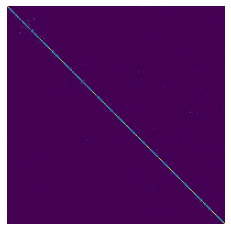

In [ ]:
plt.axis('off')
plt.imshow(mobilenet_v2.confusion_matrix)

In [ ]:
print(get_top_5_wrong(get_class_acc(mobilenet_v2.confusion_matrix)))
print(get_top_5_wrong(get_class_acc(resnet50.confusion_matrix)))
print(get_top_5_wrong(get_class_acc(resnet152.confusion_matrix)))

[('Audi TT Hatchback 2011', 0.19444444444444445), ('Audi 100 Wagon 1994', 0.35714285714285715), ('Chevrolet Silverado 1500 Hybrid Crew Cab 2012', 0.4222222222222222), ('Audi A5 Coupe 2012', 0.44680851063829785), ('Chevrolet Express Van 2007', 0.46808510638297873)]
[('Audi TT Hatchback 2011', 0.2777777777777778), ('Chevrolet Silverado 1500 Hybrid Crew Cab 2012', 0.35555555555555557), ('Audi 100 Wagon 1994', 0.38095238095238093), ('Spyker C8 Coupe 2009', 0.3958333333333333), ('Bugatti Veyron 16.4 Convertible 2009', 0.4375)]
[('Audi TT Hatchback 2011', 0.3333333333333333), ('Audi 100 Wagon 1994', 0.4523809523809524), ('Chevrolet Express Cargo Van 2007', 0.4782608695652174), ('Ferrari 458 Italia Convertible 2012', 0.48), ('Chevrolet Express Van 2007', 0.5106382978723404)]


## CAM

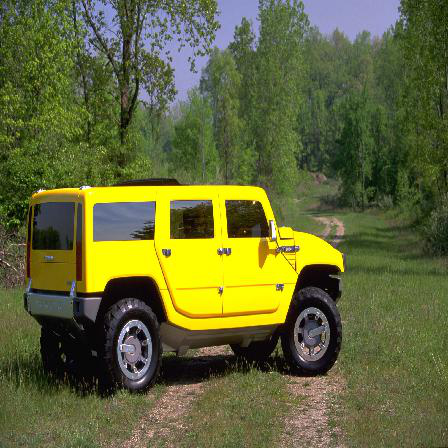

In [ ]:
# im = Image.open('/home/jovyan/data/dataset/test/Audi TT Hatchback 2011/21_31.jpg')
im = Image.open('/home/jovyan/data/dataset/test/AM General Hummer SUV 2000/0_0.jpg')
im

In [ ]:
im_processed = process_image(im)
im_processed.shape

torch.Size([1, 3, 224, 224])

In [ ]:

# -*- coding: utf-8 -*-
"""
Created on 2019/8/4 上午9:37
@author: mick.yi
"""
import numpy as np
import cv2

def get_last_conv_name(net):
    """
    获取网络的最后一个卷积层的名字
    :param net:
    :return:
    """
    layer_name = None
    for name, m in net.named_modules():
        if isinstance(m, nn.Conv2d):
            layer_name = name
    return layer_name


class GradCAM(object):
    """
    1: 网络不更新梯度,输入需要梯度更新
    2: 使用目标类别的得分做反向传播
    """

    def __init__(self, net, layer_name):
        self.net = net
        self.layer_name = layer_name
        self.feature = None
        self.gradient = None
        self.net.eval()
        self.handlers = []
        self._register_hook()

    def _get_features_hook(self, module, input, output):
        self.feature = output
        print("feature shape:{}".format(output.size()))

    def _get_grads_hook(self, module, input_grad, output_grad):
        """
        :param input_grad: tuple, input_grad[0]: None
                                   input_grad[1]: weight
                                   input_grad[2]: bias
        :param output_grad:tuple,长度为1
        :return:
        """
        self.gradient = output_grad[0]

    def _register_hook(self):
        for (name, module) in self.net.named_modules():
            if name == self.layer_name:
                self.handlers.append(module.register_forward_hook(self._get_features_hook))
                self.handlers.append(module.register_backward_hook(self._get_grads_hook))

    def remove_handlers(self):
        for handle in self.handlers:
            handle.remove()

    def __call__(self, inputs, index):
        """
        :param inputs: [1,3,H,W]
        :param index: class id
        :return:
        """
        self.net.zero_grad()
        output = self.net(inputs)  # [1,num_classes]
        if index is None:
            index = np.argmax(output.cpu().data.numpy())
        target = output[0][index]
        target.backward()

        gradient = self.gradient[0].cpu().data.numpy()  # [C,H,W]
        weight = np.mean(gradient, axis=(1, 2))  # [C]

        feature = self.feature[0].cpu().data.numpy()  # [C,H,W]

        cam = feature * weight[:, np.newaxis, np.newaxis]  # [C,H,W]
        cam = np.sum(cam, axis=0)  # [H,W]
        cam = np.maximum(cam, 0)  # ReLU

        # 数值归一化
        cam -= np.min(cam)
        cam /= np.max(cam)
        # resize to 224*224
        cam = cv2.resize(cam, (224, 224))
        return cam


class GradCamPlusPlus(GradCAM):
    def __init__(self, net, layer_name):
        super(GradCamPlusPlus, self).__init__(net, layer_name)

    def __call__(self, inputs, index):
        """
        :param inputs: [1,3,H,W]
        :param index: class id
        :return:
        """
        self.net.zero_grad()
        output = self.net(inputs)  # [1,num_classes]
        if index is None:
            index = np.argmax(output.cpu().data.numpy())
        target = output[0][index]
        target.backward()

        gradient = self.gradient[0].cpu().data.numpy()  # [C,H,W]
        gradient = np.maximum(gradient, 0.)  # ReLU
        indicate = np.where(gradient > 0, 1., 0.)  # 示性函数
        norm_factor = np.sum(gradient, axis=(1, 2))  # [C]归一化
        for i in range(len(norm_factor)):
            norm_factor[i] = 1. / norm_factor[i] if norm_factor[i] > 0. else 0.  # 避免除零
        alpha = indicate * norm_factor[:, np.newaxis, np.newaxis]  # [C,H,W]

        weight = np.sum(gradient * alpha, axis=(1, 2))  # [C]  alpha*ReLU(gradient)

        feature = self.feature[0].cpu().data.numpy()  # [C,H,W]

        cam = feature * weight[:, np.newaxis, np.newaxis]  # [C,H,W]
        cam = np.sum(cam, axis=0)  # [H,W]
        # cam = np.maximum(cam, 0)  # ReLU

        # 数值归一化
        cam -= np.min(cam)
        cam /= np.max(cam)
        # resize to 224*224
        cam = cv2.resize(cam, (224, 224))
        return cam
    
def gen_cam(image, mask):
    """
    生成CAM图
    :param image: [H,W,C],原始图像
    :param mask: [H,W],范围0~1
    :return: tuple(cam,heatmap)
    """
    # mask转为heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1]  # gbr to rgb

    # 合并heatmap到原始图像
    heatmap = np.moveaxis(heatmap, 2, 0)
    cam = heatmap + np.float32(image.cpu())
    return norm_image(cam), (heatmap * 255).astype(np.uint8)

def norm_image(image):
    """
    标准化图像
    :param image: [H,W,C]
    :return:
    """
    image = image.copy()
    image -= np.max(np.min(image), 0)
    image /= np.max(image)
    image *= 255.
    return np.uint8(image)

In [ ]:
def grad_cam_wrapper(model):
    model.eval()

    with torch.no_grad():
        print(predict(model, im_processed))
    
    image_dict = {}
    grad_cam = GradCAM(mobilenet_v2, get_last_conv_name(mobilenet_v2))
    mask = grad_cam(im_processed, 0)
    image_dict['cam'], image_dict['heatmap'] = gen_cam(im_processed, mask)
    grad_cam.remove_handlers()

    god = image_dict['cam'][0]
    plt.axis('off')
    plt.imshow(np.moveaxis(god, 0, 2))

Audi S5 Coupe 2012


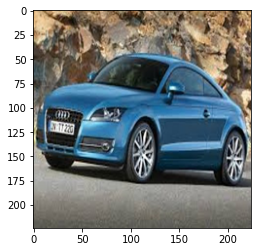

In [ ]:
densenet.eval()

with torch.no_grad():
    print(predict(densenet, im_processed))

AM General Hummer SUV 2000
feature shape:torch.Size([1, 1280, 7, 7])


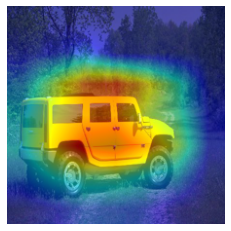

In [ ]:
grad_cam_wrapper(resnet152)

/home/jovyan/data/dataset/test/Mercedes-Benz E-Class Sedan 2012
Hyundai Genesis Sedan 2012
feature shape:torch.Size([1, 1280, 7, 7])


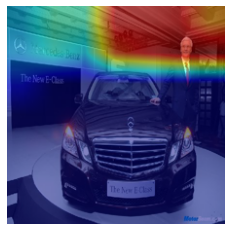

In [ ]:
import random
c = '/home/jovyan/data/dataset/test/' + random.choice(testing_set.classes)
print(c)
f = random.choice(os.listdir(c))
im = Image.open(f'{c}/{f}')
im_processed = process_image(im)
grad_cam_wrapper(resnet50)

/home/jovyan/data/dataset/test/BMW 3 Series Sedan 2012
BMW ActiveHybrid 5 Sedan 2012
feature shape:torch.Size([1, 1280, 7, 7])


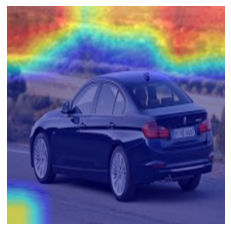

In [ ]:
import random
c = '/home/jovyan/data/dataset/test/' + random.choice(testing_set.classes)
print(c)
f = random.choice(os.listdir(c))
im = Image.open(f'{c}/{f}')
im_processed = process_image(im)
grad_cam_wrapper(resnet50)

## Loss & Accuracy Curve from Logs

In [ ]:
s1 = '2020-09-06 07:24:38,265:resnet50->epoch_end_logger:Epoch: 1 Validation Loss: 2.4990005493164062, Validation Acc: 0.3487324118614197'
s2 = '2020-09-06 07:17:14,234:resnet50->train_logger:Epoch: 1, Training_Loss: 5.340939521789551'

def extract_epoch_end(log):
    start, end = re.search('Epoch: (\d{2}|\d{1})', log).span()
    epoch = int(re.sub('[a-zA-Z]*: ', '', log[start:end]))
    
    start, end = re.search('Validation Loss: \d.(\d{15}|\d{14}|\d{13})', log).span()
    loss = float(re.sub('[a-zA-Z ]*: ', '', log[start:end]))
    
    start, end = re.search('Validation Acc: \d.(\d{15}|\d{14}|\d{13})', log).span()
    acc = float(re.sub('[a-zA-Z ]*: ', '', log[start:end]))
    
    return epoch, loss, acc

def extract_train(log):
    start, end = re.search('Epoch: (\d{2}|\d{1})', log).span()
    epoch = int(re.sub('[a-zA-Z]*: ', '', log[start:end]))
    
#     try:
    start, end = re.search('Training_Loss: \d.(\d{15}|\d{14}|\d{13}|\d{12}|\d{11}|\d{10}|\d{9}|\d{8}|\d{7})', log).span()
#     except AttributeError:
#         print('CYKA BLYAT', line)
#         return
    loss = float(re.sub('[a-zA-Z_]*: ', '', log[start:end]))
    
    return epoch, loss

In [ ]:
def load_all_loss_acc(path):
    val_losses = []
    val_accs = []
    train_losses = []
    
    with open(os.path.join(path, 'epoch_end_logs.log'), 'r') as epoch_end_log_file:
        lines = epoch_end_log_file.readlines()
        for line in lines:
            epoch, loss, acc = extract_epoch_end(line)

            val_losses.append([epoch, loss])
            val_accs.append([epoch, acc])

    val_losses = np.transpose(np.array(val_losses))
    val_accs = np.transpose(np.array(val_accs)) 
    
    with open(os.path.join(path, 'train_logs.log'), 'r') as train_log_file:
        lines = train_log_file.readlines()
        increment = 1 / (len(lines) / 30)
        for i, line in enumerate(lines):
#             print(i)
            epoch, loss = extract_train(line)
            
            i = i % 12
            epoch = epoch + (i+1)*increment

            train_losses.append([epoch, loss])
    train_losses = np.transpose(np.array(train_losses))
    
    return [val_losses, val_accs, train_losses]
    
#     fig, axs = plt.subplots(1, 2)
#     fig.set_figheight(5)
#     fig.set_figwidth(10)
#     axs[0].plot(val_losses[0], val_losses[1])
#     axs[1].plot(val_accs[0], val_accs[1])
#     plt.show()

In [ ]:
all_loss_acc = dict()

all_loss_acc['resnet18'] = load_all_loss_acc('/home/jovyan/work/model_training_featurize/models/ResNet18')
all_loss_acc['resnet34'] = load_all_loss_acc('/home/jovyan/work/model_training_featurize/models/ResNet34')
all_loss_acc['resnet50'] = load_all_loss_acc('/home/jovyan/work/model_training_featurize/models/ResNet50')
all_loss_acc['resnet101'] = load_all_loss_acc('/home/jovyan/work/model_training_featurize/models/ResNet101')
all_loss_acc['resnet152'] = load_all_loss_acc('/home/jovyan/work/model_training_featurize/models/ResNet152')
all_loss_acc['densenet'] = load_all_loss_acc('/home/jovyan/work/model_training_featurize/models/DenseNet')
all_loss_acc['mobilenet_v2'] = load_all_loss_acc('/home/jovyan/work/model_training_featurize/models/MobileNet_V2')

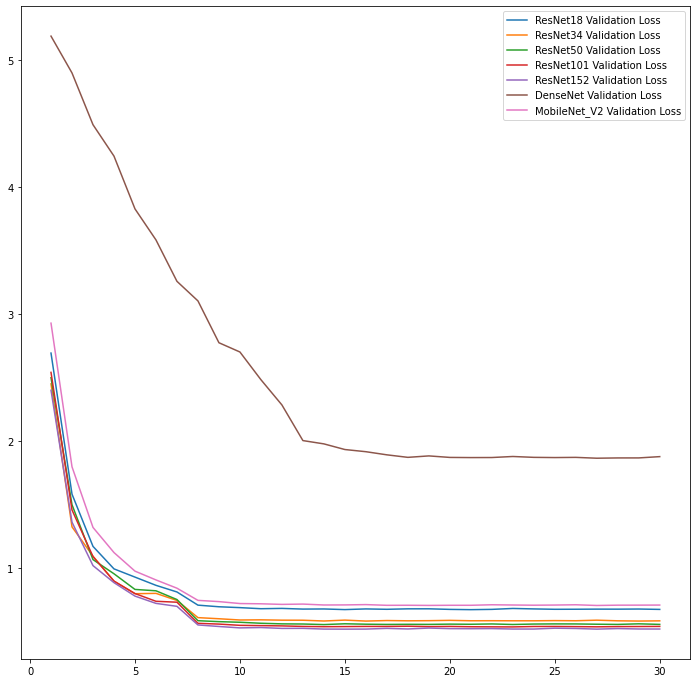

In [ ]:
plt.figure(figsize=(12,12))

plt.plot(all_loss_acc['resnet18'][0][0], all_loss_acc['resnet18'][0][1], label='ResNet18 Validation Loss')
plt.plot(all_loss_acc['resnet34'][0][0], all_loss_acc['resnet34'][0][1], label='ResNet34 Validation Loss')
plt.plot(all_loss_acc['resnet50'][0][0], all_loss_acc['resnet50'][0][1], label='ResNet50 Validation Loss')
plt.plot(all_loss_acc['resnet101'][0][0], all_loss_acc['resnet101'][0][1], label='ResNet101 Validation Loss')
plt.plot(all_loss_acc['resnet152'][0][0], all_loss_acc['resnet152'][0][1], label='ResNet152 Validation Loss')
plt.plot(all_loss_acc['densenet'][0][0], all_loss_acc['densenet'][0][1], label='DenseNet Validation Loss')
plt.plot(all_loss_acc['mobilenet_v2'][0][0], all_loss_acc['mobilenet_v2'][0][1], label='MobileNet_V2 Validation Loss')

plt.legend()
plt.show()

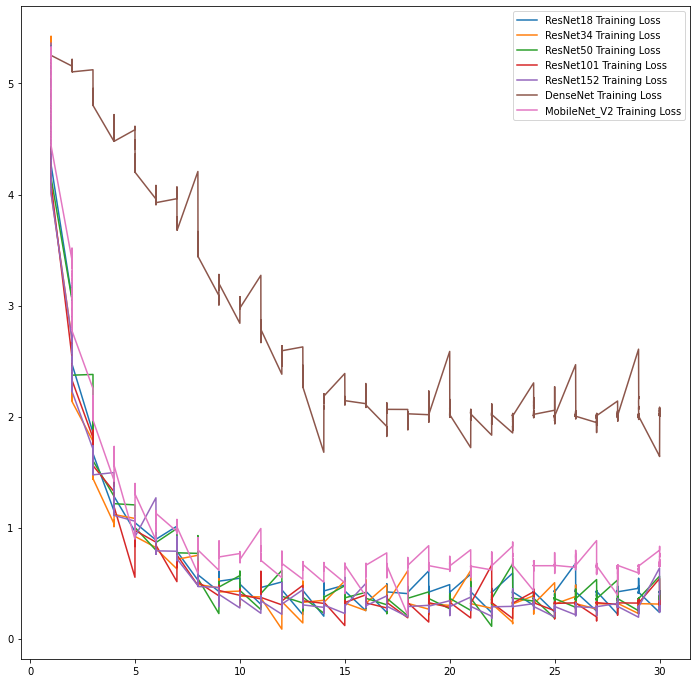

In [ ]:
plt.figure(figsize=(12,12))

plt.plot(all_loss_acc['resnet18'][2][0], all_loss_acc['resnet18'][2][1], label='ResNet18 Training Loss')
plt.plot(all_loss_acc['resnet34'][2][0], all_loss_acc['resnet34'][2][1], label='ResNet34 Training Loss')
plt.plot(all_loss_acc['resnet50'][2][0], all_loss_acc['resnet50'][2][1], label='ResNet50 Training Loss')
plt.plot(all_loss_acc['resnet101'][2][0], all_loss_acc['resnet101'][2][1], label='ResNet101 Training Loss')
plt.plot(all_loss_acc['resnet152'][2][0], all_loss_acc['resnet152'][2][1], label='ResNet152 Training Loss')
plt.plot(all_loss_acc['densenet'][2][0], all_loss_acc['densenet'][2][1], label='DenseNet Training Loss')
plt.plot(all_loss_acc['mobilenet_v2'][2][0], all_loss_acc['mobilenet_v2'][2][1], label='MobileNet_V2 Training Loss')

plt.legend()
plt.show()

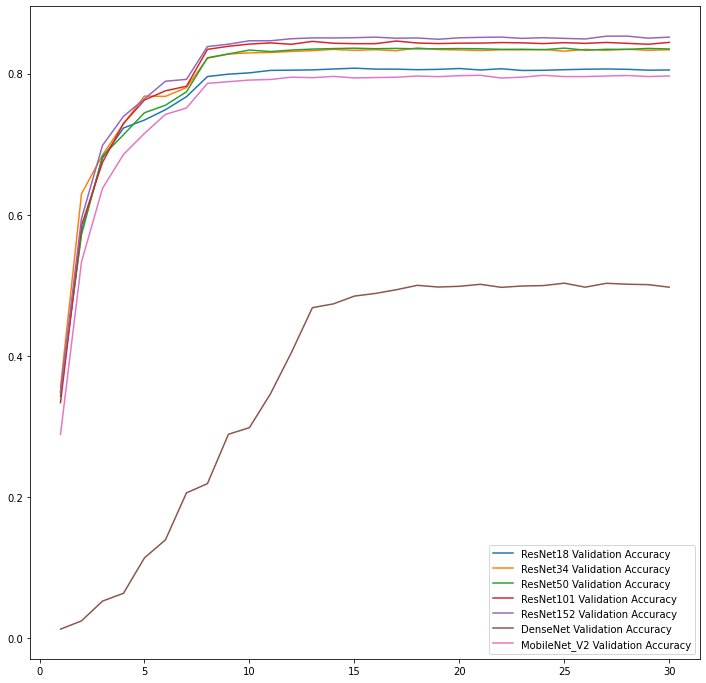

In [ ]:
plt.figure(figsize=(12,12))

plt.plot(all_loss_acc['resnet18'][1][0], all_loss_acc['resnet18'][1][1], label='ResNet18 Validation Accuracy')
plt.plot(all_loss_acc['resnet34'][1][0], all_loss_acc['resnet34'][1][1], label='ResNet34 Validation Accuracy')
plt.plot(all_loss_acc['resnet50'][1][0], all_loss_acc['resnet50'][1][1], label='ResNet50 Validation Accuracy')
plt.plot(all_loss_acc['resnet101'][1][0], all_loss_acc['resnet101'][1][1], label='ResNet101 Validation Accuracy')
plt.plot(all_loss_acc['resnet152'][1][0], all_loss_acc['resnet152'][1][1], label='ResNet152 Validation Accuracy')
plt.plot(all_loss_acc['densenet'][1][0], all_loss_acc['densenet'][1][1], label='DenseNet Validation Accuracy')
plt.plot(all_loss_acc['mobilenet_v2'][1][0], all_loss_acc['mobilenet_v2'][1][1], label='MobileNet_V2 Validation Accuracy')

plt.legend()
plt.show()